### Import modules

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from pprint import pprint
from scipy.io import loadmat
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load data

In [2]:
# each sample lasts 30 seconds (sampling rate: 200 Hz)
eeg_data = loadmat("./data/eeg_data.mat")
x = eeg_data['X_train']

# labels
sleep_stages = eeg_data['y_train']
sleep_stages[sleep_stages == 'W '] = 'W'
sleep_stages[sleep_stages == 'R '] = 'R'
print(np.unique(sleep_stages))

# targets
le = LabelEncoder()
labels = le.fit_transform(sleep_stages)
y = to_categorical(labels)

['N1' 'N2' 'N3' 'R' 'W']


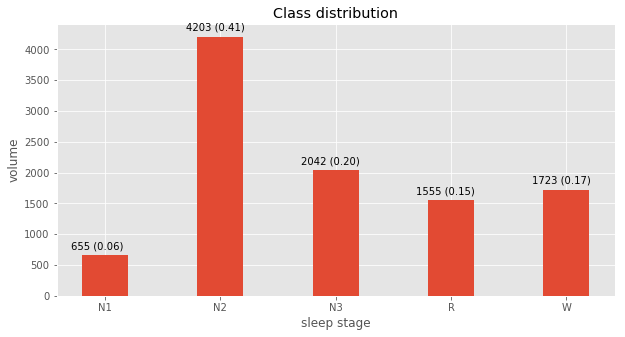

In [3]:
hx, hy = np.transpose(tuple(Counter(labels).items()))

# figure
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.set(title="Class distribution")
ax.bar(hx, hy, width=0.4)
ax.set_xticklabels([""] + [le.inverse_transform(x) for x in range(5)])
ax.set_xlabel("sleep stage")
ax.set_ylabel("volume")
total = np.sum(hy)
for i, j in zip(hx, hy):
    ax.text(i - 0.3, j + 100, "%d (%.2f)" % (j, j/total))
plt.show()

## Plot signal

In [4]:
# sub-sampling if needed
subsampling = None
x_sub = x[:, ::subsampling]
print(x.shape)

(10178, 6000)


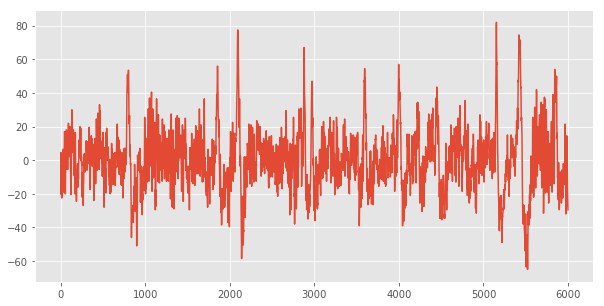

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(x_sub[0])

## CNN architecture

In [6]:
# helper functions 
def apply_conv1d(x, filter_size, stride, out_size):
    height = x.get_shape().as_list()[1]
    filter_shape = [height, filter_size, 1, out_size]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    conv = tf.nn.conv2d(x,
                        W, 
                        strides=[1, 1, stride, 1],
                        padding='VALID',
                        data_format='NHWC',
                        name='conv')
    # b = tf.Variable(tf.constant(0.1, shape=[out_size]), name='b')
    # conv = tf.nn.bias_add(conv, b)
    return conv

def stack_channels(x):
    shape = x.get_shape().as_list()
    heigth = shape[-1] 
    width = shape[2]
    return tf.reshape(x, [-1, heigth, width, 1])

def apply_max_pool1d(x, window=20, stride=1):
    height = x.get_shape().as_list()[1]
    pool = tf.nn.max_pool(x,
                          ksize=[1, height, window, 1],
                          strides=[1, 1, stride, 1], 
                          padding='VALID',
                          data_format='NHWC',
                          name='pool')
    return pool

def apply_flatten(x):
    shape = x.get_shape().as_list()
    out_size = 1
    for dim in shape[1:]:
        out_size *= dim
    return tf.reshape(x, [-1, out_size])

def apply_fully_connected(x, out_size):
    in_size = x.get_shape().as_list()[-1]
    W_o = tf.Variable(
        tf.truncated_normal(
            [in_size, out_size], stddev=0.1 ), 
            name='W_o'
    )
    b_o = tf.Variable(tf.constant(0.1, shape=[out_size]), name='b_o')
    return tf.nn.xw_plus_b(h_o, W_o, b_o, name='preds')

In [7]:
# parameters
win_sec = 1
overlap = 0.2
learning_rate = 1e-3
epsilon = 1e-8

# pretty print
n, sample_size = x_sub.shape
freq = sample_size / 30
num_classes = np.shape(y)[1]

# first pooling
win_size = int(win_sec * freq)
overlap_size = int(overlap * freq)
filter_size = win_size
stride = overlap_size
print("%d samples" % n)
print("sampling rate: %.2f Hz" % freq)
print("sample size: %d" % sample_size)
print()
print("window of %.2f seconds: filter size of %d samples" % (win_sec, win_size))
print("overlapping windows of %.2f seconds: stride of %d samples" % (overlap, overlap_size))
print()
print("number of classes: %d" % num_classes)

10178 samples
sampling rate: 200.00 Hz
sample size: 6000

window of 1.00 seconds: filter size of 200 samples
overlapping windows of 0.20 seconds: stride of 40 samples

number of classes: 5


In [8]:
%%time

# reset graph
tf.reset_default_graph()

# placeholders
x_input = tf.placeholder(tf.float32, shape=[None, sample_size], name='x_input')
y_input = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")
training_mode = tf.placeholder(tf.bool, name="training_mode")

with tf.device("/cpu:0"):
    
    with tf.name_scope("expand"):
        x_expanded = tf.reshape(x_input, [-1, 1, sample_size, 1])
    
    with tf.name_scope("convolution1"):
        conv = apply_conv1d(x_expanded, filter_size, stride, 300)
        norm = tf.layers.batch_normalization(conv, training=training_mode)
        relu = tf.nn.relu(norm)
        h_pool = apply_max_pool1d(relu, window=20, stride=1)
        
    with tf.name_scope("stack"):
        h_stack = stack_channels(h_pool)
        
    with tf.name_scope("dropout1"):
        h_drop = tf.nn.dropout(h_stack, dropout)
        
    with tf.name_scope("convolution2"):
        conv2 = apply_conv1d(h_drop, 30, 1, 100)
        norm2 = tf.layers.batch_normalization(conv2, training=training_mode)
        relu2 = tf.nn.relu(norm2)
        h2_pool = apply_max_pool1d(relu2, window=10, stride=1)
        
    with tf.name_scope("flatten"): 
        h_flat = apply_flatten(h2_pool)
        
    with tf.name_scope("dropout2"):
        h_o = tf.nn.dropout(h_flat, dropout)

    with tf.name_scope("fully_connect"):
        preds = apply_fully_connected(h_o, num_classes)
        
    with tf.name_scope("loss"):
        losses = tf.nn.softmax_cross_entropy_with_logits(
            logits=preds,
            labels=y_input,
            name='losses'
        )
        loss = tf.reduce_mean(losses, name='loss')

    with tf.name_scope("optimization"):
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(
                learning_rate=learning_rate,
                epsilon=epsilon,
            )
            train_op = optimizer.minimize(loss) 
        
    with tf.name_scope("accuracy"):
        labels_pred = tf.argmax(preds, axis=1) 
        labels_true = tf.argmax(y_input, axis=1)
        correct_predictions = tf.equal(labels_pred, labels_true)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
        
    init = tf.global_variables_initializer()

CPU times: user 790 ms, sys: 10 ms, total: 800 ms
Wall time: 799 ms


In [9]:
%%time
n_try = 4
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub[:n_try], y_input: y[:n_try], dropout: 1, training_mode: False}
    __ = sess.run(accuracy, feed_dict=D)
    
print(__)

0.5
CPU times: user 196 ms, sys: 18 ms, total: 214 ms
Wall time: 94.9 ms


In [10]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub, y_input: y, dropout: 1, training_mode: True}
    acc, lb_pred, lb_true = sess.run([accuracy, labels_pred, labels_true], feed_dict=D)
    
print(acc)
print(Counter(lb_pred))
print(Counter(lb_true))

0.107487
Counter({0: 7187, 4: 2821, 2: 95, 1: 43, 3: 32})
Counter({1: 4203, 2: 2042, 4: 1723, 3: 1555, 0: 655})
CPU times: user 2min 50s, sys: 2.23 s, total: 2min 53s
Wall time: 11.3 s


In [11]:
batch_size = 64
num_epochs = 30
p = 0.6
seed = 10
split = train_test_split(x_sub, y, labels, train_size=0.75, random_state=seed)
x_train, x_test, y_train, y_test, labels_train, labels_test = split

def get_stat(sess, x, y, 
                x_input=x_input, y_input=y_input, dropout=dropout, training_mode=training_mode):
    feed_dict={x_input: x, y_input: y, dropout: 1, training_mode: False}
    acc, l = sess.run([accuracy, loss], feed_dict=feed_dict)
    return acc, l

In [12]:
# emptying tensorflow_summmaries
path = "./tensorflow_summaries/"
for file in os.listdir(path):
    filepath = path + file
    if os.path.isfile(filepath):
        os.remove(filepath)

In [13]:
%%time

# training
np.random.seed(10)
with tf.Session() as sess:
    # init
    sess.run(init)
    acc_train, __ = get_stat(sess, x_train, y_train)
    acc_test, __ = get_stat(sess, x_test, y_test)
    print("init.: __ train acc: %0.2f test acc: %0.2f" % (acc_train, acc_test))
    
    # training
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_ys = y_train[idx: idxn]
            feed_train = {x_input: batch_xs, y_input: batch_ys, dropout: p, training_mode: True}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)
            
        acc_train, __ = get_stat(sess, x_train, y_train)
        acc_test, __ = get_stat(sess, x_test, y_test)
        print("epoch: %02d train acc: %0.2f test acc: %0.2f" % (e, acc_train, acc_test))
        
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)
    
    # use trained model
    feed = {x_input: x_test, y_input: y_test, dropout: 1, training_mode: False}
    lb_pred, lb_true = sess.run([labels_pred, labels_true], feed_dict=feed)
    
# close file writer
file_writer.close()

init.: __ train acc: 0.41 test acc: 0.42
epoch: 00 train acc: 0.28 test acc: 0.29
epoch: 01 train acc: 0.52 test acc: 0.53
epoch: 02 train acc: 0.59 test acc: 0.61
epoch: 03 train acc: 0.58 test acc: 0.59
epoch: 04 train acc: 0.61 test acc: 0.61
epoch: 05 train acc: 0.64 test acc: 0.64
epoch: 06 train acc: 0.67 test acc: 0.67
epoch: 07 train acc: 0.72 test acc: 0.71
epoch: 08 train acc: 0.71 test acc: 0.70
epoch: 09 train acc: 0.73 test acc: 0.71
epoch: 10 train acc: 0.74 test acc: 0.72
epoch: 11 train acc: 0.77 test acc: 0.76
epoch: 12 train acc: 0.78 test acc: 0.76
epoch: 13 train acc: 0.76 test acc: 0.74
epoch: 14 train acc: 0.75 test acc: 0.74
epoch: 15 train acc: 0.78 test acc: 0.76
epoch: 16 train acc: 0.78 test acc: 0.76
epoch: 17 train acc: 0.78 test acc: 0.76
epoch: 18 train acc: 0.80 test acc: 0.78
epoch: 19 train acc: 0.80 test acc: 0.78
epoch: 20 train acc: 0.77 test acc: 0.75
epoch: 21 train acc: 0.79 test acc: 0.76
epoch: 22 train acc: 0.80 test acc: 0.77
epoch: 23 train 

In [14]:
Counter(np.argmax(batch_ys, axis=1))

Counter({0: 2, 1: 24, 2: 14, 3: 12, 4: 12})

Counter({1: 917, 3: 582, 2: 573, 4: 451, 0: 22})
Counter({1: 1066, 2: 517, 4: 414, 3: 399, 0: 149})


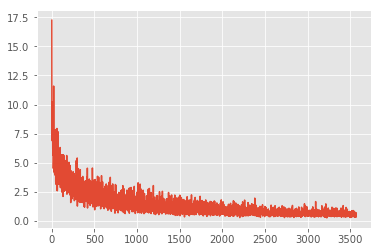

In [15]:
plt.plot(losses)
print(Counter(lb_pred))
print(Counter(lb_true))

In [16]:
print(lb_true[lb_pred == 1])

[2 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 3 1 0 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 2 1 1 1
 1 1 1 4 1 1 2 2 1 4 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 4 1 1 1 1 0 1 1 4 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 4 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 0 1 2 0 2 1 1 1 1 1 1 1 1 1 2 3 1 1 2 1 1 1 0 1 4
 1 1 1 1 1 4 1 1 1 2 4 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1 1 1 1 1 1 0 4 1 2 0 1
 2 1 1 1 3 1 1 1 1 1 1 1 1 1 2 1 2 0 1 1 1 1 1 3 1 1 2 1 1 1 0 1 2 1 1 1 1
 1 2 0 1 1 1 1 1 1 1 1 1 